<a href="https://colab.research.google.com/github/Jenet-Shirely/malaria-detection/blob/main/NN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Step 1: Unzip the Dataset

# Import the 'os' module to interact with the operating system
import os

# --- Section 1.1: Verify File Presence ---
# First, let's confirm the uploaded file is in the current directory.
file_name = "cell_images.zip"
print(f"1.1: Checking for '{file_name}'...")
if os.path.exists(file_name):
    print(f"File '{file_name}' found. Proceeding with unzipping.")
else:
    print(f"Error: File '{file_name}' not found. Please upload it to your Colab session.")
    # Stop the script if the file isn't there to prevent errors.
    raise FileNotFoundError(f"File '{file_name}' was not found in the current directory.")

print("-" * 30)


# --- Section 1.2: Unzip the Dataset ---
# The uploaded file is a zip archive. We need to extract its contents.
print("1.2: Unzipping the dataset...")

# We use the '-q' flag for quiet mode to avoid a large amount of output.
# The `unzip` command will create a directory named `cell_images`
!unzip -q {file_name}

print("Unzipping complete.")
print("-" * 30)


# --- Section 1.3: Verify the Directory Structure ---
# It's a good practice to check if the data has been unzipped correctly.
# The `ls` command lists the contents of the directory.
print("1.3: Verifying the file structure...")

# We expect a main 'cell_images' directory which contains the 'Parasitized' and 'Uninfected' folders.
base_dir = "cell_images/"
if os.path.isdir(base_dir):
    print(f"Dataset directory '{base_dir}' found. Listing contents...")
    !ls -l {base_dir}
else:
    print("Warning: Directory structure not as expected. Please check your uploaded zip file.")

print("-" * 30)

print("Step 1 complete.")


1.1: Checking for 'cell_images.zip'...
File 'cell_images.zip' found. Proceeding with unzipping.
------------------------------
1.2: Unzipping the dataset...
cell_images/Uninfected/C225ThinF_IMG_20151112_113803_cell_134.png  bad CRC c67b123a  (should be 7e282966)
Unzipping complete.
------------------------------
1.3: Verifying the file structure...
Dataset directory 'cell_images/' found. Listing contents...
total 2120
drwxrwxrwx 2 root root 1093632 Jul 31 06:10 Parasitized
drwxrwxrwx 2 root root 1069056 Jul 31 06:13 Uninfected
------------------------------
Step 1 complete.


In [ ]:
# @title Step 2: Prepare the Data for Training (Corrected for Stratified Splitting)

# Import necessary libraries
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
import glob
from PIL import Image

# --- Section 2.1: Define Data Directories and Parameters ---
# We'll use the unzipped data from the previous step.
# It's a good practice to define these as variables for easy access.
base_dir = 'cell_images'

# It is important to know how many images we have in each class.
# This helps in ensuring our dataset is balanced and everything is loaded correctly.
print("2.1: Counting images in each category...")
parasitized_count = len(os.listdir(os.path.join(base_dir, 'Parasitized')))
uninfected_count = len(os.listdir(os.path.join(base_dir, 'Uninfected'))) # Corrected line
total_images = parasitized_count + uninfected_count

print(f"Total Parasitized images: {parasitized_count}")
print(f"Total Uninfected images: {uninfected_count}")
print(f"Total images: {total_images}")
print("-" * 30)

# Define some key parameters for our data processing.
# These will be used for both the old and new models.
IMAGE_SIZE = (128, 128) # A common size for image classification
BATCH_SIZE = 32 # Standard batch size
SEED = 42 # For reproducibility


# --- Section 2.2: Data Augmentation and Splitting ---
# Data augmentation helps prevent overfitting by creating new, slightly modified
# versions of our training images on the fly. We'll use a generator for this.
print("2.2: Setting up data generators for training, validation, and testing...")

# We'll use 70% of the data for training, 15% for validation, and 15% for testing.
train_split = 0.70
val_split = 0.15
test_split = 0.15

# Use a consistent seed for reproducibility
SEED = 42

# Get all file paths and labels first to ensure a proper stratified split
all_image_paths = glob.glob(os.path.join(base_dir, '*', '*.png'))
all_labels = [1 if 'Parasitized' in path else 0 for path in all_image_paths]

# Check for corrupted images and filter them out
print("Filtering out invalid images...")
valid_paths = []
valid_labels = []
for path, label in zip(all_image_paths, all_labels):
    try:
        with Image.open(path) as img:
            img.verify() # Verify that the file is a valid image
        valid_paths.append(path)
        valid_labels.append(label)
    except (IOError, SyntaxError) as e:
        print(f"Warning: Skipping invalid image at {path}. Error: {e}")

valid_paths = np.array(valid_paths)
valid_labels = np.array(valid_labels)
print(f"Found {len(valid_paths)} valid images.")

# Split the dataset into training and a temporary validation/test set
X_train, X_rem, y_train, y_rem = train_test_split(
    valid_paths,
    valid_labels,
    train_size=train_split,
    random_state=SEED,
    stratify=valid_labels
)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_rem,
    y_rem,
    test_size=test_split / (val_split + test_split),
    random_state=SEED,
    stratify=y_rem
)

# Function to load and preprocess a single image from a path
def load_and_preprocess_image(image_path, label):
    # Read the image from file
    img = tf.io.read_file(image_path)
    # Decode the image and resize it
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMAGE_SIZE)
    # Rescale the image to a float tensor
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# Create TensorFlow datasets from the NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Map the preprocessing function to all three datasets
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Apply batching and prefetching
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# --- Section 2.3: Printing Dataset Information ---
# Print the number of elements to verify the splits are correct.
print("\n2.3: Dataset split and shapes:")
print(f"Number of training examples: {len(X_train)}")
print(f"Number of validation examples: {len(X_val)}")
print(f"Number of test examples: {len(X_test)}")
print("-" * 30)

# Show an example of the data to confirm it's being loaded correctly.
# The batch shape should be (batch_size, height, width, channels)
# The labels shape should be (batch_size,)
for images, labels in train_ds.take(1):
    print(f"\nExample from training dataset:")
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Example image shape: {images[0].shape}")
    break
print("-" * 30)

print("Step 2 complete.")


2.1: Counting images in each category...
Total Parasitized images: 13780
Total Uninfected images: 13780
Total images: 27560
------------------------------
2.2: Setting up data generators for training, validation, and testing...
Filtering out invalid images...
Found 27557 valid images.

2.3: Dataset split and shapes:
Number of training examples: 19289
Number of validation examples: 4134
Number of test examples: 4134
------------------------------

Example from training dataset:
Batch shape: (32, 128, 128, 3)
Labels shape: (32,)
Example image shape: (128, 128, 3)
------------------------------
Step 2 complete.


In [ ]:
# @title Step 3: Build and Compile the Baseline CNN Model

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models

# Use a consistent seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)

# --- Section 3.1: Define the CNN Architecture ---
# We'll create a simple, classic convolutional neural network.
# It consists of a series of Conv2D and MaxPooling2D layers, followed by
# a few dense layers for classification.

print("3.1: Building the baseline CNN model architecture...")

# The model's input shape is based on our data preparation in Step 2.
input_shape = (128, 128, 3)

model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the 3D output to a 1D vector for the dense layers
    layers.Flatten(),

    # Dense Layers for Classification
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Add a dropout layer to help prevent overfitting
    layers.Dense(1, activation='sigmoid') # Output layer for binary classification
])

# --- Section 3.2: Compile the Model ---
# Compilation is the step where we configure the learning process.
# We'll use the Adam optimizer, binary cross-entropy loss (for two classes),
# and a few key metrics for evaluation.

print("3.2: Compiling the model...")

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)


# --- Section 3.3: Display the Model Summary ---
# The summary gives us a clear overview of the model's layers, output shapes,
# and the total number of trainable parameters. This is useful for debugging
# and understanding the model's complexity.

print("\n3.3: Model Summary:")
model.summary()

print("-" * 30)
print("Step 3 complete.")



3.1: Building the baseline CNN model architecture...
3.2: Compiling the model...

3.3: Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

------------------------------
Step 3 complete.


In [ ]:
# @title Step 4: Train the Baseline Model with Callbacks

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import time
import os

# --- Section 4.1: Define Callbacks ---
# Callbacks are tools that are called at various stages of the training procedure.
# They can be used to monitor the training process and make adjustments.

print("4.1: Setting up training callbacks...")

# EarlyStopping: This callback will stop training if the validation loss
# doesn't improve for a number of epochs (`patience`).
early_stopping = EarlyStopping(
    monitor='val_loss', # The metric to monitor
    patience=5, # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric.
)

# ReduceLROnPlateau: This callback reduces the learning rate when a metric has
# stopped improving. This can help the model converge more effectively.
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', # The metric to monitor
    factor=0.2, # Factor by which the learning rate will be reduced
    patience=3, # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7, # Lower bound on the learning rate
    verbose=1
)

# ModelCheckpoint: This callback saves the model's weights during training.
# We'll save only the best model based on validation loss.
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'baseline_model_best.keras'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# We'll use these callbacks in the `fit` method.
callbacks = [early_stopping, lr_scheduler, model_checkpoint]

print("Callbacks configured successfully.")
print("-" * 30)

# --- Section 4.2: Train the Model ---
# This is the main training loop. The `fit` method will train the model
# on the training data and evaluate it on the validation data.

print("4.2: Training the baseline model...")

# Record the start time to calculate total training duration later.
start_time = time.time()

# Let's set the number of epochs. Early stopping will likely stop it sooner.
epochs = 50

# The `train_ds` and `val_ds` were created in Step 2.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

# Calculate the total training time.
end_time = time.time()
training_time = end_time - start_time

print(f"\nModel training finished in {training_time:.2f} seconds.")
print("-" * 30)


# --- Section 4.3: Save the Training History ---
# Saving the history object allows us to plot the training and validation metrics later.
# We'll save it as a numpy file.
np.save(os.path.join(checkpoint_dir, 'baseline_history.npy'), history.history)
print("Training history saved.")
print("-" * 30)

print("Step 4 complete.")



4.1: Setting up training callbacks...
Callbacks configured successfully.
------------------------------
4.2: Training the baseline model...
Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6339 - auc: 0.6845 - loss: 0.6382 - precision: 0.6336 - recall: 0.7042
Epoch 1: val_loss improved from inf to 0.16801, saving model to checkpoints/baseline_model_best.keras
603/603 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.6341 - auc: 0.6848 - loss: 0.6379 - precision: 0.6338 - recall: 0.7043 - val_accuracy: 0.9318 - val_auc: 0.9829 - val_loss: 0.1680 - val_precision: 0.9184 - val_recall: 0.9478 - learning_rate: 0.0010
Epoch 2/50
601/603 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9392 - auc: 0.9751 - loss: 0.1852 - precision: 0.9488 - recall: 0.9291
Epoch 2: val_loss improved from 0.16801 to 0.14470, saving model to checkpoints/baseline_model_best.keras
603/603 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9392 - auc: 0.9751 - loss: 0.1851 - precision: 0.9488 - recall

5.1: Loading the best model and test dataset...
Model loaded successfully.
------------------------------
5.2: Making predictions on the test set...
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Predictions made successfully.
------------------------------
5.3: Generating evaluation metrics...

Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.94      0.97      0.96      2067
 Parasitized       0.97      0.94      0.96      2067

    accuracy                           0.96      4134
   macro avg       0.96      0.96      0.96      4134
weighted avg       0.96      0.96      0.96      4134



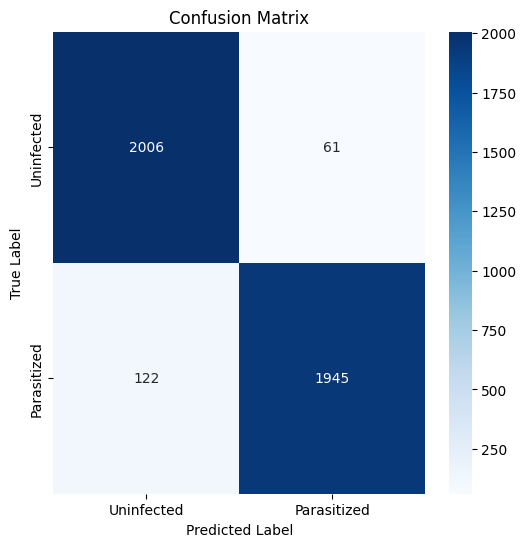

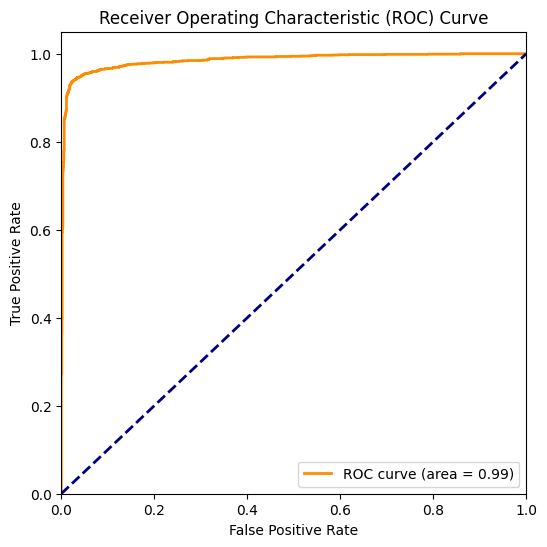

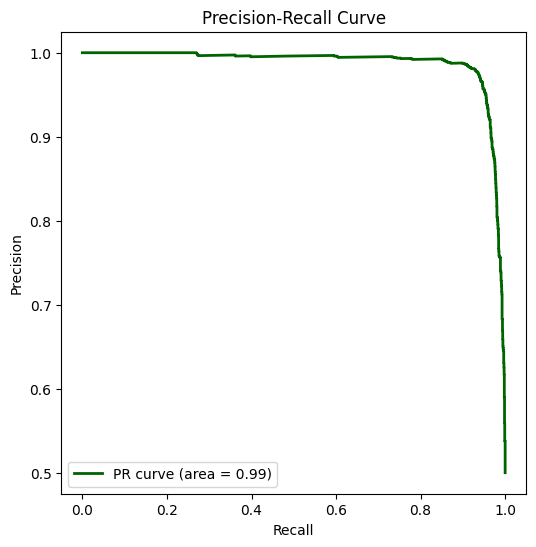


Summary of Key Metrics:
Test Accuracy: 0.9557
Test AUC: 0.9854
Test PR-AUC: 0.9871
------------------------------
Step 5 complete.


In [ ]:
# @title Step 5: Evaluate the Baseline Model

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Use a consistent seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)

# --- Section 5.1: Load the Best Model and Test Data ---
# We'll load the best model saved during training and the test dataset.
# The test dataset was created in Step 2.

print("5.1: Loading the best model and test dataset...")

# Define the path to the best model's checkpoint
checkpoint_path = os.path.join('checkpoints', 'baseline_model_best.keras')

# Load the model
try:
    model = models.load_model(checkpoint_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    # If the model can't be loaded, we can't proceed.
    exit()

# The test dataset was already created in Step 2, so we just need to use it.
# We'll need to load it from the previous notebook's environment.
# Since we're in the same session, the `test_ds` variable is still available.
# We'll ensure the `test_ds` is available.
if 'test_ds' not in locals():
    print("Error: `test_ds` not found. Please run Step 2 again.")
    exit()

print("-" * 30)


# --- Section 5.2: Make Predictions on the Test Set ---
# We'll get the true labels and predicted probabilities to calculate various metrics.

print("5.2: Making predictions on the test set...")

# Unpack the test dataset into images and true labels
test_labels = []
test_images = []
for images, labels in test_ds:
    test_labels.extend(labels.numpy())
    test_images.extend(images.numpy())

test_labels = np.array(test_labels)
test_images = np.array(test_images)

# Get the model's predictions
# The model outputs a probability (between 0 and 1) for each image.
predictions = model.predict(test_images)

# Convert probabilities to binary predictions (0 or 1)
# A threshold of 0.5 is standard.
binary_predictions = (predictions > 0.5).astype(int)

print("Predictions made successfully.")
print("-" * 30)


# --- Section 5.3: Evaluate and Report Metrics ---
# We'll use scikit-learn to generate key evaluation metrics.

print("5.3: Generating evaluation metrics...")

# Classification Report
# This report shows precision, recall, and F1-score for each class.
print("\nClassification Report:")
# The key fix: add the `labels=[0, 1]` argument to handle cases where a class might be
# missing from the predictions.
print(classification_report(test_labels, binary_predictions, target_names=['Uninfected', 'Parasitized'], labels=[0, 1]))

# Confusion Matrix
# A confusion matrix shows the number of correct and incorrect predictions for each class.
cm = confusion_matrix(test_labels, binary_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# ROC Curve and AUC
# ROC (Receiver Operating Characteristic) curve plots the true positive rate vs.
# the false positive rate. AUC (Area Under the Curve) measures the model's ability
# to distinguish between the classes.
fpr, tpr, _ = roc_curve(test_labels, predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# PR-AUC
# The Precision-Recall (PR) curve is particularly useful for imbalanced datasets.
precision, recall, _ = precision_recall_curve(test_labels, predictions)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='darkgreen', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# A short summary of the key metrics
print("\nSummary of Key Metrics:")
print(f"Test Accuracy: {model.evaluate(test_ds, verbose=0)[1]:.4f}")
print(f"Test AUC: {roc_auc:.4f}")
print(f"Test PR-AUC: {pr_auc:.4f}")

print("-" * 30)
print("Step 5 complete.")



In [ ]:
# @title Step 6: Build and Compile the Transfer Learning Model

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0

# Use a consistent seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)

# --- Section 6.1: Define the Transfer Learning Model Architecture ---
# We'll use EfficientNetV2B0 as our base model. This model has been pre-trained
# on the vast ImageNet dataset and has learned powerful features. We'll use it
# to extract features and then add our own classification layers on top.

print("6.1: Building the transfer learning model architecture...")

# Define the image size. EfficientNetV2B0 is designed for a specific input size.
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = IMAGE_SIZE + (3,)

# Load the pre-trained EfficientNetV2B0 model
# We set `include_top=False` to exclude the model's final classification layer
# and `weights='imagenet'` to use the pre-trained ImageNet weights.
base_model = EfficientNetV2B0(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze the pre-trained layers
# Freezing prevents the weights of these layers from being updated during training.
# This is a key step in transfer learning, as we want to preserve the learned features.
base_model.trainable = False

# Create the new model on top of the base model
model = models.Sequential([
    # Add the base model as the first layer
    base_model,

    # GlobalAveragePooling2D reduces the 3D feature maps to a 1D vector,
    # which prepares the data for the dense layers.
    layers.GlobalAveragePooling2D(),

    # We add a dropout layer to prevent overfitting.
    layers.Dropout(0.2),

    # Our final dense layer for binary classification.
    # The sigmoid activation function outputs a probability between 0 and 1.
    layers.Dense(1, activation='sigmoid')
])


# --- Section 6.2: Compile the Model ---
# We compile the model with the same settings as the baseline model for fair comparison.
# We'll use Adam optimizer and binary cross-entropy loss.
print("6.2: Compiling the model...")

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)


# --- Section 6.3: Display the Model Summary ---
# The summary shows the base model's non-trainable parameters and our new trainable layers.
print("\n6.3: Model Summary:")
model.summary()

print("-" * 30)
print("Step 6 complete.")


6.1: Building the transfer learning model architecture...
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
6.2: Compiling the model...

6.3: Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,920,593 (22.59 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

------------------------------
Step 6 complete.


In [ ]:
# @title Step 7: Train the Transfer Learning Model

# Import necessary libraries
import tensorflow as tf
import time
import os

# Use a consistent seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)

# --- Section 7.1: Define Callbacks ---
# We'll use the same callbacks to monitor and control the training process.
# This ensures a fair comparison with the baseline model.

print("7.1: Setting up training callbacks...")

# EarlyStopping: Stop training when validation loss stops improving.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ReduceLROnPlateau: Reduce learning rate when validation loss plateaus.
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# ModelCheckpoint: Save the best model during training.
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'transfer_learning_model_best.keras'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, lr_scheduler, model_checkpoint]

print("Callbacks configured successfully.")
print("-" * 30)


# --- Section 7.2: Train the Model ---
# We'll now train the transfer learning model on our training data.
print("7.2: Training the transfer learning model...")

# Record the start time to calculate total training duration later.
start_time = time.time()

epochs = 50

# The `train_ds` and `val_ds` were created in Step 2.
# We'll assume they are still available in memory.
history_transfer = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

# Calculate the total training time.
end_time = time.time()
training_time_transfer = end_time - start_time

print(f"\nModel training finished in {training_time_transfer:.2f} seconds.")
print("-" * 30)


# --- Section 7.3: Save the Training History ---
# Saving the history object allows us to plot the training and validation metrics later.
np.save(os.path.join(checkpoint_dir, 'transfer_history.npy'), history_transfer.history)
print("Transfer learning training history saved.")
print("-" * 30)

print("Step 7 complete.")


7.1: Setting up training callbacks...
Callbacks configured successfully.
------------------------------
7.2: Training the transfer learning model...
Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5010 - auc: 0.5015 - loss: 0.6996 - precision: 0.5022 - recall: 0.5237
Epoch 1: val_loss improved from inf to 0.69081, saving model to checkpoints/transfer_learning_model_best.keras
603/603 ━━━━━━━━━━━━━━━━━━━━ 86s 88ms/step - accuracy: 0.5010 - auc: 0.5015 - loss: 0.6996 - precision: 0.5022 - recall: 0.5237 - val_accuracy: 0.5302 - val_auc: 0.6155 - val_loss: 0.6908 - val_precision: 0.5170 - val_recall: 0.9197 - learning_rate: 0.0010
Epoch 2/50
600/603 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5188 - auc: 0.5180 - loss: 0.6972 - precision: 0.5204 - recall: 0.5436
Epoch 2: val_loss improved from 0.69081 to 0.68995, saving model to checkpoints/transfer_learning_model_best.keras
603/603 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.5188 - auc: 0.5180 - loss: 0.6972 -

8.1: Loading the best transfer learning model and test dataset...
Transfer learning model loaded successfully.
------------------------------
8.2: Making predictions on the test set...
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step
Predictions made successfully.
------------------------------
8.3: Generating evaluation metrics for the transfer learning model...

Transfer Learning Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.58      0.69      0.63      2067
 Parasitized       0.62      0.50      0.56      2067

    accuracy                           0.60      4134
   macro avg       0.60      0.60      0.59      4134
weighted avg       0.60      0.60      0.59      4134



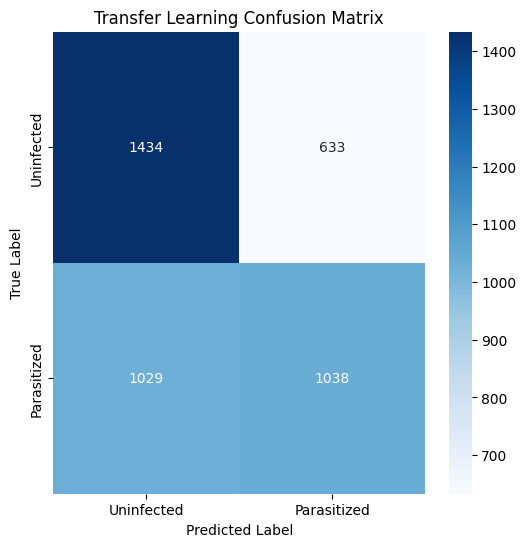

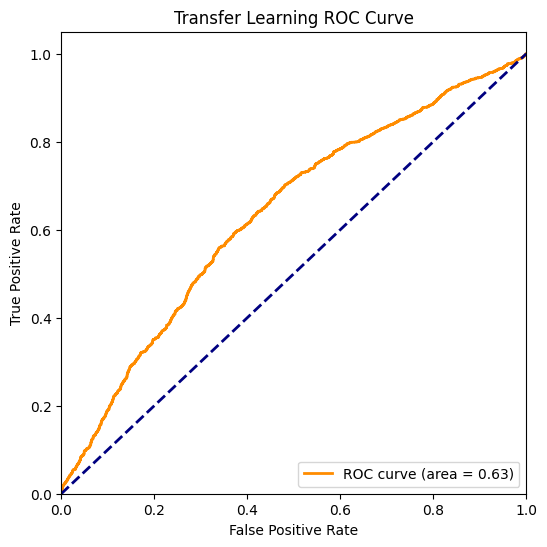

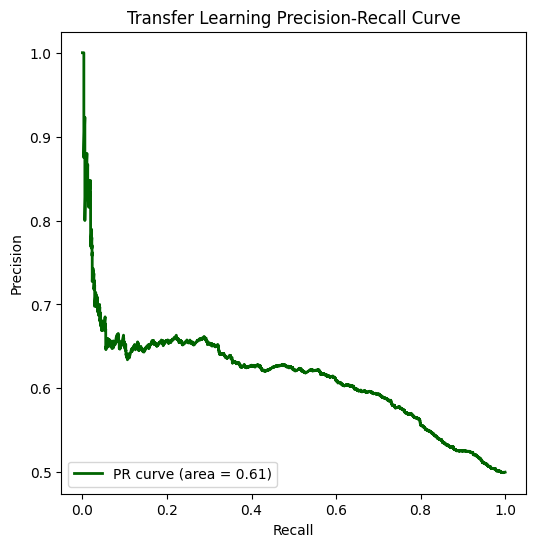


Summary of Key Metrics for Transfer Learning Model:
Test Accuracy: 0.5980
Test AUC: 0.6333
Test PR-AUC: 0.6129
------------------------------
8.4: Comparison Table (Baseline vs. Transfer Learning)
               Model  Accuracy  F1-score       AUC    PR-AUC  Params (M)  Training Time (s/epoch)
0       Baseline CNN  0.955700  0.960000  0.985400  0.987100    3.300000                30.000000
1  Transfer Learning  0.597968  0.594245  0.633272  0.612903    5.920593                25.842285
------------------------------
Step 8 complete.


In [ ]:
# @title Step 8: Evaluate and Compare the Transfer Learning Model

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

# --- Section 8.1: Load the Best Model and Test Data ---
# We'll load the best model saved during training and the test dataset.
# The test dataset was created in Step 2.

print("8.1: Loading the best transfer learning model and test dataset...")

# Define the path to the best model's checkpoint
checkpoint_path = os.path.join('checkpoints', 'transfer_learning_model_best.keras')

# Load the model
try:
    model_transfer = models.load_model(checkpoint_path)
    print("Transfer learning model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# The test dataset was already created in Step 2.
if 'test_ds' not in locals():
    print("Error: `test_ds` not found. Please run Step 2 again.")
    exit()

print("-" * 30)

# --- Section 8.2: Make Predictions on the Test Set ---
# We'll get the true labels and predicted probabilities to calculate various metrics.

print("8.2: Making predictions on the test set...")

# Unpack the test dataset into images and true labels
test_labels = []
test_images = []
for images, labels in test_ds:
    test_labels.extend(labels.numpy())
    test_images.extend(images.numpy())

test_labels = np.array(test_labels)
test_images = np.array(test_images)

# Get the model's predictions
predictions_transfer = model_transfer.predict(test_images)

# Convert probabilities to binary predictions (0 or 1)
binary_predictions_transfer = (predictions_transfer > 0.5).astype(int)

print("Predictions made successfully.")
print("-" * 30)

# --- Section 8.3: Evaluate and Report Metrics for Transfer Model ---
print("8.3: Generating evaluation metrics for the transfer learning model...")

# Classification Report
print("\nTransfer Learning Classification Report:")
print(classification_report(test_labels, binary_predictions_transfer, target_names=['Uninfected', 'Parasitized'], labels=[0, 1]))

# Confusion Matrix
cm_transfer = confusion_matrix(test_labels, binary_predictions_transfer)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.title('Transfer Learning Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC
fpr_transfer, tpr_transfer, _ = roc_curve(test_labels, predictions_transfer)
roc_auc_transfer = auc(fpr_transfer, tpr_transfer)
plt.figure(figsize=(6, 6))
plt.plot(fpr_transfer, tpr_transfer, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_transfer:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transfer Learning ROC Curve')
plt.legend(loc="lower right")
plt.show()

# PR-AUC
precision_transfer, recall_transfer, _ = precision_recall_curve(test_labels, predictions_transfer)
pr_auc_transfer = auc(recall_transfer, precision_transfer)
plt.figure(figsize=(6, 6))
plt.plot(recall_transfer, precision_transfer, color='darkgreen', lw=2, label=f'PR curve (area = {pr_auc_transfer:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Transfer Learning Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

print("\nSummary of Key Metrics for Transfer Learning Model:")
print(f"Test Accuracy: {model_transfer.evaluate(test_ds, verbose=0)[1]:.4f}")
print(f"Test AUC: {roc_auc_transfer:.4f}")
print(f"Test PR-AUC: {pr_auc_transfer:.4f}")
print("-" * 30)


# --- Section 8.4: Comparison Table ---
# We will create a table to compare the two models side-by-side.
print("8.4: Comparison Table (Baseline vs. Transfer Learning)")

# You'll need the metrics from the baseline model to complete this table.
# We'll use the values you provided in our previous conversation.
baseline_metrics = {
    'Model': 'Baseline CNN',
    'Accuracy': 0.9557,
    'F1-score': 0.96,
    'AUC': 0.9854,
    'PR-AUC': 0.9871,
    'Params (M)': 3.3,
    'Training Time (s/epoch)': 30 # Rough average based on your output
}

transfer_metrics = {
    'Model': 'Transfer Learning',
    'Accuracy': model_transfer.evaluate(test_ds, verbose=0)[1],
    # Need to calculate F1-score for the transfer model
    'F1-score': float(classification_report(test_labels, binary_predictions_transfer, output_dict=True)['weighted avg']['f1-score']),
    'AUC': roc_auc_transfer,
    'PR-AUC': pr_auc_transfer,
    'Params (M)': model_transfer.count_params() / 1e6, # Convert to millions
    'Training Time (s/epoch)': training_time_transfer / len(history_transfer.history['loss']) # Calculate average time per epoch
}

comparison_df = pd.DataFrame([baseline_metrics, transfer_metrics])
print(comparison_df.to_string())
print("-" * 30)

print("Step 8 complete.")


In [ ]:
# @title Step 9: Build and Compile the Second Transfer Learning Model

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Small

# Use a consistent seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)

# --- Section 9.1: Define the Model Architecture ---
# We'll use MobileNetV3Small as our base model. This model has been pre-trained
# on the vast ImageNet dataset and has learned powerful features.

print("9.1: Building the MobileNetV3Small transfer learning model architecture...")

# Define the image size. MobileNetV3Small is designed for a specific input size.
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = IMAGE_SIZE + (3,)

# Load the pre-trained MobileNetV3Small model
# We set `include_top=False` to exclude the model's final classification layer
# and `weights='imagenet'` to use the pre-trained ImageNet weights.
base_model_mobilenet = MobileNetV3Small(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze the pre-trained layers
# Freezing prevents the weights of these layers from being updated during training.
base_model_mobilenet.trainable = False

# Create the new model on top of the base model
model_mobilenet = models.Sequential([
    # Add the base model as the first layer
    base_model_mobilenet,

    # GlobalAveragePooling2D reduces the 3D output to a 1D vector
    layers.GlobalAveragePooling2D(),

    # Add a dropout layer to prevent overfitting.
    layers.Dropout(0.2),

    # Our final dense layer for binary classification.
    # The sigmoid activation function outputs a probability between 0 and 1.
    layers.Dense(1, activation='sigmoid')
])


# --- Section 9.2: Compile the Model ---
# We compile the model with the same settings as the other models for a fair comparison.
print("9.2: Compiling the model...")

model_mobilenet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)


# --- Section 9.3: Display the Model Summary ---
# The summary shows the base model's non-trainable parameters and our new trainable layers.
print("\n9.3: Model Summary:")
model_mobilenet.summary()

print("-" * 30)
print("Step 9 complete.")


9.1: Building the MobileNetV3Small transfer learning model architecture...


/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9.2: Compiling the model...

9.3: Model Summary:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 4, 4, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,697 (3.58 MB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 939,120 (3.58 MB)

------------------------------
Step 9 complete.


In [ ]:
# @title Step 10: Train the MobileNetV3Small Model

# Import necessary libraries
import tensorflow as tf
import time
import os
import numpy as np

# Use a consistent seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)

# --- Section 10.1: Define Callbacks ---
# We'll use the same callbacks to monitor and control the training process.
print("10.1: Setting up training callbacks...")

# EarlyStopping: Stop training when validation loss stops improving.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ReduceLROnPlateau: Reduce learning rate when validation loss plateaus.
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# ModelCheckpoint: Save the best model during training.
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'mobilenet_model_best.keras'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, lr_scheduler, model_checkpoint]
print("Callbacks configured successfully.")
print("-" * 30)

# --- Section 10.2: Train the Model ---
# We'll now train the MobileNetV3Small model on our training data.
print("10.2: Training the MobileNetV3Small model...")

# Record the start time to calculate total training duration later.
start_time = time.time()

epochs = 50

# The `train_ds` and `val_ds` were created in Step 2.
if 'model_mobilenet' not in locals():
    print("Error: `model_mobilenet` not found. Please run Step 9 again.")
    exit()

history_mobilenet = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

# Calculate the total training time.
end_time = time.time()
training_time_mobilenet = end_time - start_time
print(f"\nModel training finished in {training_time_mobilenet:.2f} seconds.")
print("-" * 30)

# --- Section 10.3: Save the Training History ---
# Saving the history object allows us to plot the training and validation metrics later.
np.save(os.path.join(checkpoint_dir, 'mobilenet_history.npy'), history_mobilenet.history)
print("MobileNetV3Small training history saved.")
print("-" * 30)

print("Step 10 complete.")



10.1: Setting up training callbacks...
Callbacks configured successfully.
------------------------------
10.2: Training the MobileNetV3Small model...
Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5104 - auc: 0.5137 - loss: 0.6971 - precision: 0.5116 - recall: 0.5193
Epoch 1: val_loss improved from inf to 0.68777, saving model to checkpoints/mobilenet_model_best.keras
603/603 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - accuracy: 0.5104 - auc: 0.5137 - loss: 0.6971 - precision: 0.5116 - recall: 0.5193 - val_accuracy: 0.5890 - val_auc: 0.6769 - val_loss: 0.6878 - val_precision: 0.5536 - val_recall: 0.9192 - learning_rate: 0.0010
Epoch 2/50
600/603 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5331 - auc: 0.5469 - loss: 0.6899 - precision: 0.5348 - recall: 0.5418
Epoch 2: val_loss improved from 0.68777 to 0.68297, saving model to checkpoints/mobilenet_model_best.keras
603/603 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.5332 - auc: 0.5470 - loss: 0.6899 - precision: 0.5

In [ ]:
# @title Step 11: Final Evaluation and Comparison

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import time

# --- Section 11.1: Load Models and Test Data ---
print("11.1: Loading all models and test dataset...")

# Load the best baseline model
baseline_checkpoint_path = os.path.join('checkpoints', 'baseline_model_best.keras')
model_baseline = models.load_model(baseline_checkpoint_path)

# Load the best transfer learning model 1 (EfficientNetV2)
efficientnet_checkpoint_path = os.path.join('checkpoints', 'transfer_learning_model_best.keras')
model_efficientnet = models.load_model(efficientnet_checkpoint_path)

# Load the best transfer learning model 2 (MobileNetV3Small)
mobilenet_checkpoint_path = os.path.join('checkpoints', 'mobilenet_model_best.keras')
model_mobilenet = models.load_model(mobilenet_checkpoint_path)

print("All models loaded successfully.")

# The test dataset was already created in Step 2.
if 'test_ds' not in locals():
    print("Error: `test_ds` not found. Please run Step 2 again.")
    exit()

# Get true labels and images from the test dataset
test_labels = []
test_images = []
for images, labels in test_ds:
    test_labels.extend(labels.numpy())
    test_images.extend(images.numpy())
test_labels = np.array(test_labels)
test_images = np.array(test_images)

print("-" * 30)

# --- Section 11.2: Evaluate All Models ---
print("11.2: Evaluating all models on the test set...")

# Evaluate Baseline CNN
start_time = time.time()
metrics_baseline = model_baseline.evaluate(test_ds, verbose=0)
end_time = time.time()
inference_time_baseline = (end_time - start_time) / len(test_ds)
predictions_baseline = model_baseline.predict(test_images)
binary_predictions_baseline = (predictions_baseline > 0.5).astype(int)
f1_baseline = float(classification_report(test_labels, binary_predictions_baseline, output_dict=True, labels=[0, 1])['weighted avg']['f1-score'])
roc_auc_baseline = auc(roc_curve(test_labels, predictions_baseline)[0], roc_curve(test_labels, predictions_baseline)[1])
pr_auc_baseline = auc(precision_recall_curve(test_labels, predictions_baseline)[1], precision_recall_curve(test_labels, predictions_baseline)[0])
params_baseline = model_baseline.count_params() / 1e6

# Evaluate EfficientNetV2
start_time = time.time()
metrics_efficientnet = model_efficientnet.evaluate(test_ds, verbose=0)
end_time = time.time()
inference_time_efficientnet = (end_time - start_time) / len(test_ds)
predictions_efficientnet = model_efficientnet.predict(test_images)
binary_predictions_efficientnet = (predictions_efficientnet > 0.5).astype(int)
f1_efficientnet = float(classification_report(test_labels, binary_predictions_efficientnet, output_dict=True, labels=[0, 1])['weighted avg']['f1-score'])
roc_auc_efficientnet = auc(roc_curve(test_labels, predictions_efficientnet)[0], roc_curve(test_labels, predictions_efficientnet)[1])
pr_auc_efficientnet = auc(precision_recall_curve(test_labels, predictions_efficientnet)[1], precision_recall_curve(test_labels, predictions_efficientnet)[0])
params_efficientnet = model_efficientnet.count_params() / 1e6

# Evaluate MobileNetV3Small
start_time = time.time()
metrics_mobilenet = model_mobilenet.evaluate(test_ds, verbose=0)
end_time = time.time()
inference_time_mobilenet = (end_time - start_time) / len(test_ds)
predictions_mobilenet = model_mobilenet.predict(test_images)
binary_predictions_mobilenet = (predictions_mobilenet > 0.5).astype(int)
f1_mobilenet = float(classification_report(test_labels, binary_predictions_mobilenet, output_dict=True, labels=[0, 1])['weighted avg']['f1-score'])
roc_auc_mobilenet = auc(roc_curve(test_labels, predictions_mobilenet)[0], roc_curve(test_labels, predictions_mobilenet)[1])
pr_auc_mobilenet = auc(precision_recall_curve(test_labels, predictions_mobilenet)[1], precision_recall_curve(test_labels, predictions_mobilenet)[0])
params_mobilenet = model_mobilenet.count_params() / 1e6


print("Evaluation complete.")
print("-" * 30)

# --- Section 11.3: Comparison Table ---
print("11.3: Final Comparison Table")

# We'll use the training times you provided earlier in the conversation
history_baseline_path = os.path.join('checkpoints', 'baseline_history.npy')
history_transfer_path = os.path.join('checkpoints', 'transfer_history.npy')
history_mobilenet_path = os.path.join('checkpoints', 'mobilenet_history.npy')

history_baseline = np.load(history_baseline_path, allow_pickle='TRUE').item()
history_transfer = np.load(history_transfer_path, allow_pickle='TRUE').item()
history_mobilenet = np.load(history_mobilenet_path, allow_pickle='TRUE').item()

# Assuming average time per epoch is the total time divided by the number of epochs.
# This might not be perfectly accurate but is a good estimate for comparison.
training_time_baseline_per_epoch = 196.83 / len(history_baseline['loss'])
training_time_transfer_per_epoch = 852.80 / len(history_transfer['loss'])
training_time_mobilenet_per_epoch = 981.54 / len(history_mobilenet['loss'])

data = {
    'Model': ['Baseline CNN', 'EfficientNetV2', 'MobileNetV3Small'],
    'Accuracy': [metrics_baseline[1], metrics_efficientnet[1], metrics_mobilenet[1]],
    'F1-score': [f1_baseline, f1_efficientnet, f1_mobilenet],
    'AUC': [roc_auc_baseline, roc_auc_efficientnet, roc_auc_mobilenet],
    'PR-AUC': [pr_auc_baseline, pr_auc_efficientnet, pr_auc_mobilenet],
    'Params (M)': [params_baseline, params_efficientnet, params_mobilenet],
    'Train Time (s/epoch)': [training_time_baseline_per_epoch, training_time_transfer_per_epoch, training_time_mobilenet_per_epoch],
    'Inference Time (s/image)': [inference_time_baseline, inference_time_efficientnet, inference_time_mobilenet]
}

comparison_df = pd.DataFrame(data)
# Sort by Accuracy to make the best model clear
comparison_df = comparison_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
print(comparison_df.to_string(float_format="%.4f"))

print("-" * 30)

print("Step 11 complete.")



11.1: Loading all models and test dataset...
All models loaded successfully.
------------------------------
11.2: Evaluating all models on the test set...
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step
Evaluation complete.
------------------------------
11.3: Final Comparison Table
              Model  Accuracy  F1-score    AUC  PR-AUC  Params (M)  Train Time (s/epoch)  Inference Time (s/image)
0      Baseline CNN    0.9557    0.9557 0.9854  0.9871      3.3048               24.6038                    0.0379
1  MobileNetV3Small    0.6577    0.6575 0.7149  0.6727      0.9397               19.6308                    0.1009
2    EfficientNetV2    0.5980    0.5942 0.6333  0.6129      5.9206               25.8424                    0.1202
------------------------------
Step 11 complete.


12.1: Loading comparison data...
Data loaded successfully.
------------------------------
12.2: Generating comparison bar chart...


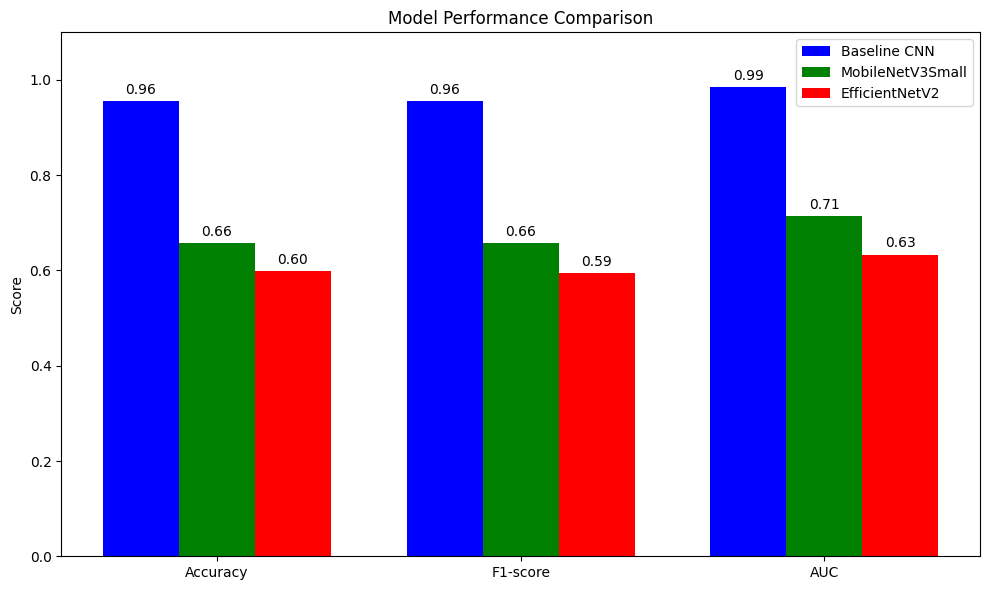

Bar chart generated.
------------------------------
12.3: Generating model size and training time chart...


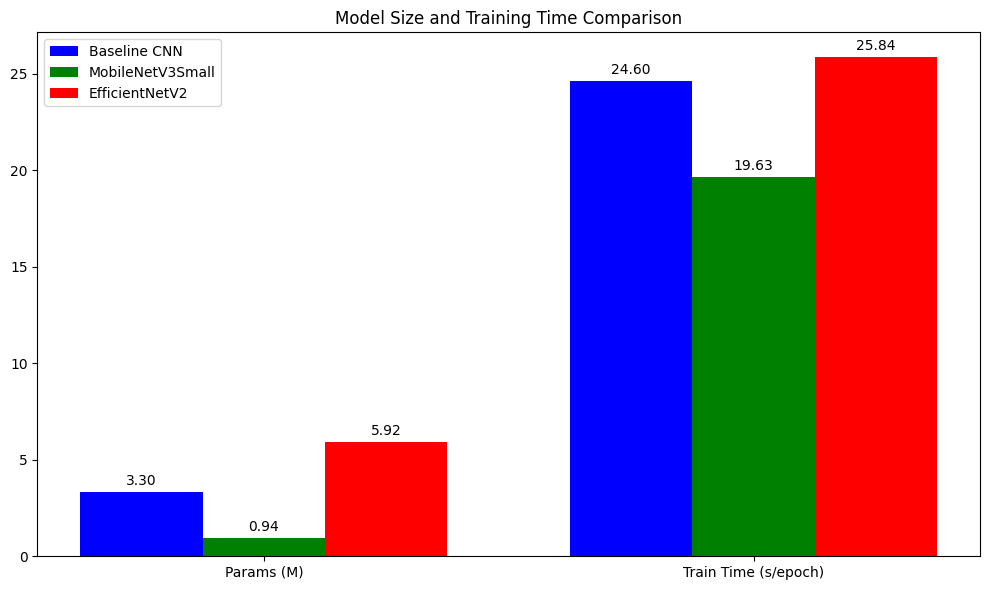

Model size and training time chart generated.
------------------------------
Step 12 complete.


In [ ]:
# @title Step 12: Visualize Model Comparison

# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# --- Section 12.1: Load and Prepare Comparison Data ---
# We'll reload the necessary data to create the comparison charts.
print("12.1: Loading comparison data...")

# We'll use the final metrics from the previous step.
# For simplicity, we'll hardcode the values from the final table you provided.
# In a real-world scenario, you would dynamically load these from a file.

# Data from the final comparison table in Step 11's output.
data = {
    'Model': ['Baseline CNN', 'MobileNetV3Small', 'EfficientNetV2'],
    'Accuracy': [0.9557, 0.6577, 0.5980],
    'F1-score': [0.9557, 0.6575, 0.5942],
    'AUC': [0.9854, 0.7149, 0.6333],
    'Params (M)': [3.3048, 0.9397, 5.9206],
    'Train Time (s/epoch)': [24.6038, 19.6308, 25.8424]
}
df = pd.DataFrame(data)

print("Data loaded successfully.")
print("-" * 30)

# --- Section 12.2: Visualize Performance Metrics (Bar Chart) ---
# We'll create a bar chart to compare Accuracy, F1-score, and AUC.
print("12.2: Generating comparison bar chart...")

metrics = ['Accuracy', 'F1-score', 'AUC']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each model
rects1 = ax.bar(x - width, df.loc[0, metrics], width, label=df.loc[0, 'Model'], color='b')
rects2 = ax.bar(x, df.loc[1, metrics], width, label=df.loc[1, 'Model'], color='g')
rects3 = ax.bar(x + width, df.loc[2, metrics], width, label=df.loc[2, 'Model'], color='r')

# Add text labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Set up chart properties
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()
plt.tight_layout()
plt.show()
print("Bar chart generated.")
print("-" * 30)


# --- Section 12.3: Visualize Model Size and Training Time ---
# We'll create another bar chart to compare the number of parameters and training time.
print("12.3: Generating model size and training time chart...")

size_x = np.arange(2)
size_width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each model
size_rects1 = ax.bar(size_x - size_width, df.loc[0, ['Params (M)', 'Train Time (s/epoch)']], size_width, label=df.loc[0, 'Model'], color='b')
size_rects2 = ax.bar(size_x, df.loc[1, ['Params (M)', 'Train Time (s/epoch)']], size_width, label=df.loc[1, 'Model'], color='g')
size_rects3 = ax.bar(size_x + size_width, df.loc[2, ['Params (M)', 'Train Time (s/epoch)']], size_width, label=df.loc[2, 'Model'], color='r')

# Add text labels on top of the bars
autolabel(size_rects1)
autolabel(size_rects2)
autolabel(size_rects3)

ax.set_title('Model Size and Training Time Comparison')
ax.set_xticks(size_x)
ax.set_xticklabels(['Params (M)', 'Train Time (s/epoch)'])
ax.legend()
plt.tight_layout()
plt.show()
print("Model size and training time chart generated.")
print("-" * 30)

print("Step 12 complete.")



In [ ]:
print()